In [2]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import librosa
import glob
import librosa.display
from tqdm import tqdm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from tabulate import tabulate
from pprint import pprint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTROGRAMS_DIR = './../data/spectrograms/'
AUDIO_MFCCS_DIR = './../data/mfccs/'
AUDIO_MEL_SPECTROGRAMS_DIR = './../data/mel_spectrograms/'
AUDIO_MEL_SPECTROGRAM_IMAGES_DIR = './../data/mel_spectrogram_images/'


config = Configuration.load_json(CONFIG_FILE)
# !pip install autokeras
# !pip install --upgrade scipy==1.7.0
# !pip install auto-sklearn
import autokeras as ak
# from autosklearn.classification import AutoSklearnClassifier
# from autosklearn.regression import AutoSklearnRegressor

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}
plt.rcParams['figure.dpi'] = 300

In [7]:
def get_metrics(y_labels, y_pred, draw_corr_matrix=True):
    folds_size = 1106
    accs = []
    i = 0
    for f_i in range(5):
      acc = round(metrics.accuracy_score(
          y_labels[i:i+folds_size], y_pred[i:i+folds_size]) * 100, 2)
      print(f"Accuracy for fold {f_i}: {acc}%")
      accs.append(acc)

      i += folds_size

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

In [8]:
def categorical_cross_validation(get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  X = np.asarray(list(data_df["x"].values))
  y = np.asarray(data_df["y"].values)
  
  all_y_pred = []
  all_y_labels = []

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    print(f'Training for fold {fold_no} ...')
    train, test = data_df.loc[train], data_df.loc[test]
        
    model.fit(np.asarray(list(train["x"].values)),
              np.asarray(train["y"].values),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1,
              max_queue_size=-1)

    y_pred = model.predict(np.asarray(list(test["x"].values)))
    all_y_pred.extend([np.argmax(x) for x in y_pred])
    all_y_labels.extend([y for y in np.asarray(test["y"].values)])

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred

callback = EarlyStopping(monitor='loss', patience=5, verbose=2)
no_epochs = 100
batch_size = 64

verbosity = 1
num_folds = 5

## AutoKeras - Spectrogram as a Feature

In [4]:
def get_new_model():
    return ak.ImageClassifier(overwrite=False, max_trials=20, seed=1, directory=f"spectrogram_cat_autokeras")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def get_y_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    with open(audio_file, 'rb') as f:
        spec = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return spec, int(emotion)

def get_y_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    with open(audio_file, 'rb') as f:
        spec = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return spec, int(OneHotEncodingConfig[emotion])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [256, 256]), tf.reshape(labels, [1])

def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_y_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [256, 256]), tf.reshape(labels, [4])

def preprocess_dataset(files, oneHotEncoding=False):
  filenames_ds = tf.data.Dataset.list_files(files)
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

data_df = preprocess_dataset(glob.glob(f"{AUDIO_SPECTROGRAMS_DIR}*.pickle"))
data_df = data_df.batch(8)
data_df = data_df.cache().prefetch(AUTOTUNE)

In [5]:
data_df = pd.DataFrame({"x": [], "y": []})

def get_spec_and_label(audio_file):
    with open(audio_file, 'rb') as f:
        spec = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return spec, int(emotion)

for file in tqdm(glob.glob(f'{AUDIO_SPECTROGRAMS_DIR}*.pickle')):
    data_df.loc[len(data_df.index)] = get_spec_and_label(file)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [00:38<00:00, 144.40it/s] 


In [14]:
def categorical_cross_validation(get_new_model, train_ds, callback, no_epochs,
                                 batch_size, verbosity):
    model = get_new_model()

    model.fit(data_df,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1)
    
    model = model.export_model()
    print(type(model))
    try:
        model.save("model_autokeras", save_format="tf")
    except Exception:
        model.save("model_autokeras.h5")

callback = EarlyStopping(monitor='val_loss', patience=5)
no_epochs = 70
batch_size = 64
verbosity = 1

categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity)



Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
True              |True              |image_block_1/normalize
True              |True              |image_block_1/augment
xception          |efficient         |image_block_1/block_type
global_avg        |global_avg        |classification_head_1/spatial_reduction_1/reduction_type
0                 |0                 |classification_head_1/dropout
adam              |adam              |optimizer
2e-05             |2e-05             |learning_rate
0.1               |0.1               |image_block_1/image_augmentation_1/translation_factor
True              |True              |image_block_1/image_augmentation_1/horizontal_flip
True              |True              |image_block_1/image_augmentation_1/vertical_flip
0                 |0                 |image_block_1/image_augmentation_1/rotation_factor
0                 |0                 |image_block_1/image_augmentation_1/zoom_factor
0                 |0          

KeyboardInterrupt: 

In [ ]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
vanilla           |?                 |image_block_1/block_type
True              |?                 |image_block_1/normalize
False             |?                 |image_block_1/augment
3                 |?                 |image_block_1/conv_block_1/kernel_size
1                 |?                 |image_block_1/conv_block_1/num_blocks
2                 |?                 |image_block_1/conv_block_1/num_layers
True              |?                 |image_block_1/conv_block_1/max_pooling
False             |?                 |image_block_1/conv_block_1/separable
0.25              |?                 |image_block_1/conv_block_1/dropout
32                |?                 |image_block_1/conv_block_1/filters_0_0
64                |?                 |image_block_1/conv_block_1/filters_0_1
flatten           |?                 |classification_head_1/spatial_reduction_1/reduction_type
0.5     

# SOA Model 1

In [9]:
def build_model_1(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(32, (9, 9), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), strides=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (6, 6), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (6, 6), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (6, 6), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (6, 6), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 1)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)


Model: "sequential_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      2624      Y          
                                                                            
 activation_8 (Activation)   (None, 128, 128, 32)      0         Y          
                                                                            
 batch_normalization_7 (Batc  (None, 128, 128, 32)     128       Y          
 hNormalization)                                                            
                                                                            
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        100416    Y          
                                                                            
 activation_9 (Activation)   (None, 64, 64, 64)        0         Y          
                                                      

## Spectrogram as a Feature

In [10]:
data_df = pd.DataFrame({"x": [], "y": []})

def get_spec_and_label(audio_file):
    with open(audio_file, 'rb') as f:
        spec = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return spec, int(emotion)

for file in tqdm(glob.glob(f'{AUDIO_SPECTROGRAMS_DIR}*.pickle')):
    data_df.loc[len(data_df.index)] = get_spec_and_label(file)

0it [00:00, ?it/s]


In [66]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 6s 71ms/step - loss: 1.6030 - accuracy: 0.4250
Epoch 2/50
70/70 [==============================] - 5s 78ms/step - loss: 1.3270 - accuracy: 0.4584
Epoch 3/50
70/70 [==============================] - 5s 72ms/step - loss: 1.2379 - accuracy: 0.4892
Epoch 4/50
70/70 [==============================] - 5s 74ms/step - loss: 1.3587 - accuracy: 0.4919
Epoch 5/50
70/70 [==============================] - 5s 75ms/step - loss: 1.0476 - accuracy: 0.5561
Epoch 6/50
70/70 [==============================] - 5s 78ms/step - loss: 0.9924 - accuracy: 0.5897
Epoch 7/50
70/70 [==============================] - 5s 78ms/step - loss: 0.9775 - accuracy: 0.5961
Epoch 8/50
70/70 [==============================] - 6s 79ms/step - loss: 1.0182 - accuracy: 0.5902
Epoch 9/50
70/70 [==============================] - 6s 81ms/step - loss: 0.8842 - accuracy: 0.6514
Epoch 10/50
70/70 [==============================] - 6s 82ms/step - loss: 0.7982 - ac

Metric               Value
-----------------  -------
Accuracy            46
F1 score macro      45.92
Precision           47.09
Recall              45.53
Matthews corrcoef    0.264


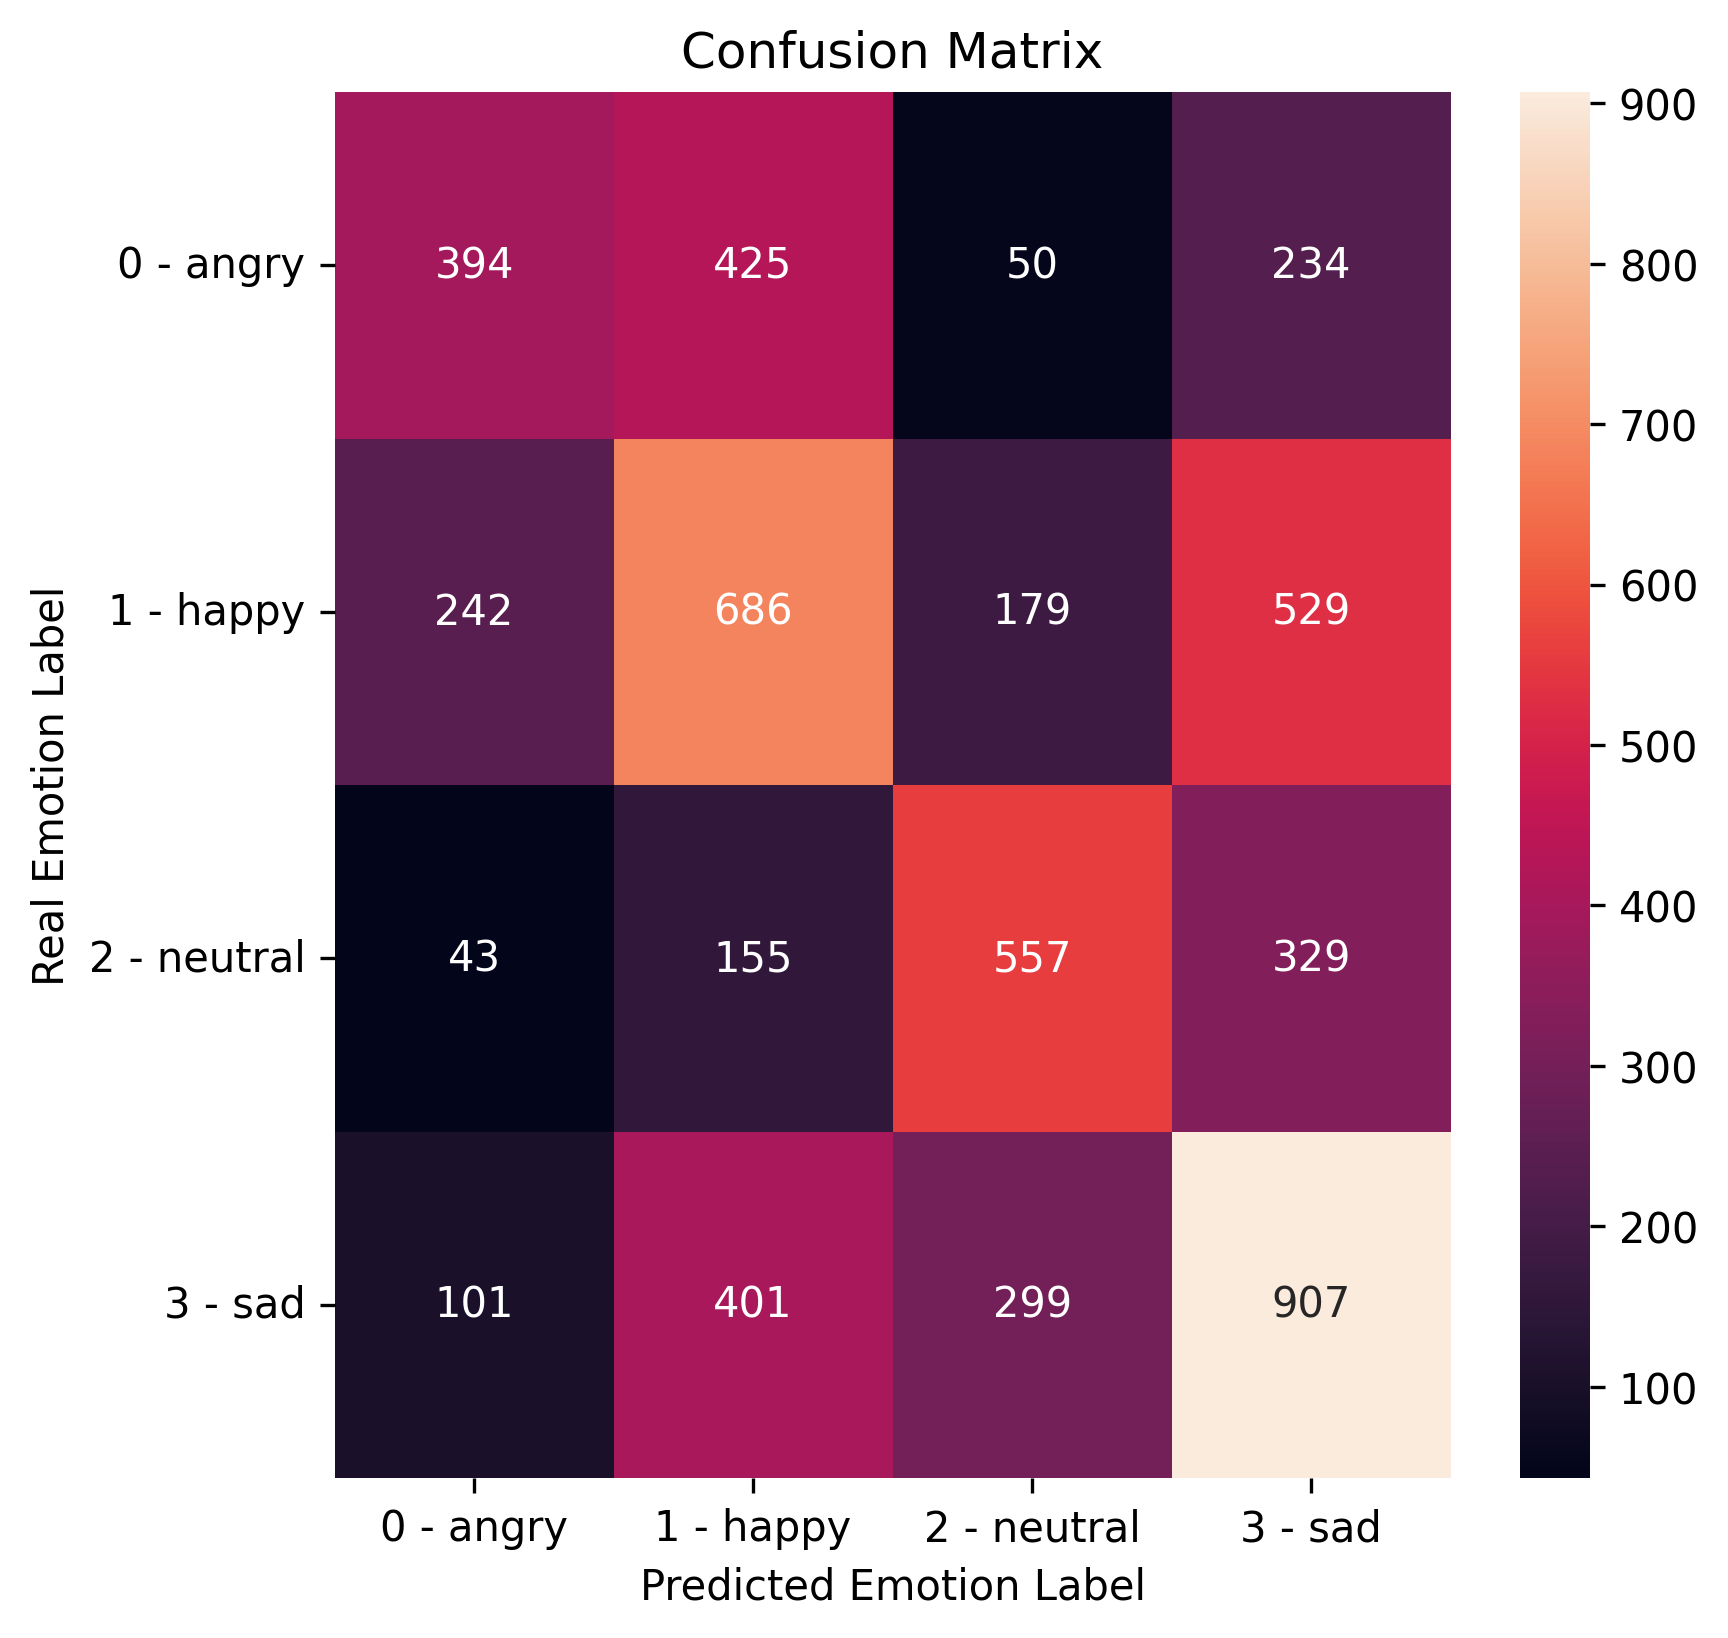

In [ ]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

## MFCCs as a Feature

In [70]:
data_df = pd.DataFrame({"x": [], "y": []})

def get_y_and_label(audio_file):
    with open(audio_file, 'rb') as f:
        y = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return y, int(emotion)

for file in tqdm(glob.glob(f'{AUDIO_MFCCS_DIR}*.pickle')):
    data_df.loc[len(data_df.index)] = get_y_and_label(file)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [01:01<00:00, 89.51it/s] 


In [71]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 7s 91ms/step - loss: 1.4712 - accuracy: 0.3840
Epoch 2/50
70/70 [==============================] - 7s 94ms/step - loss: 1.1964 - accuracy: 0.4801
Epoch 3/50
70/70 [==============================] - 7s 95ms/step - loss: 1.0611 - accuracy: 0.5454
Epoch 4/50
70/70 [==============================] - 7s 96ms/step - loss: 0.9573 - accuracy: 0.5929
Epoch 5/50
70/70 [==============================] - 7s 97ms/step - loss: 0.8526 - accuracy: 0.6426
Epoch 6/50
70/70 [==============================] - 7s 98ms/step - loss: 0.7370 - accuracy: 0.6994
Epoch 7/50
70/70 [==============================] - 7s 98ms/step - loss: 0.6797 - accuracy: 0.7229
Epoch 8/50
70/70 [==============================] - 7s 97ms/step - loss: 0.5684 - accuracy: 0.7807
Epoch 9/50
70/70 [==============================] - 7s 98ms/step - loss: 0.4857 - accuracy: 0.8153
Epoch 10/50
70/70 [==============================] - 7s 98ms/step - loss: 0.4060 - ac

Metric               Value
-----------------  -------
Accuracy            41.49
F1 score macro      41.45
Precision           42.54
Recall              40.88
Matthews corrcoef    0.201


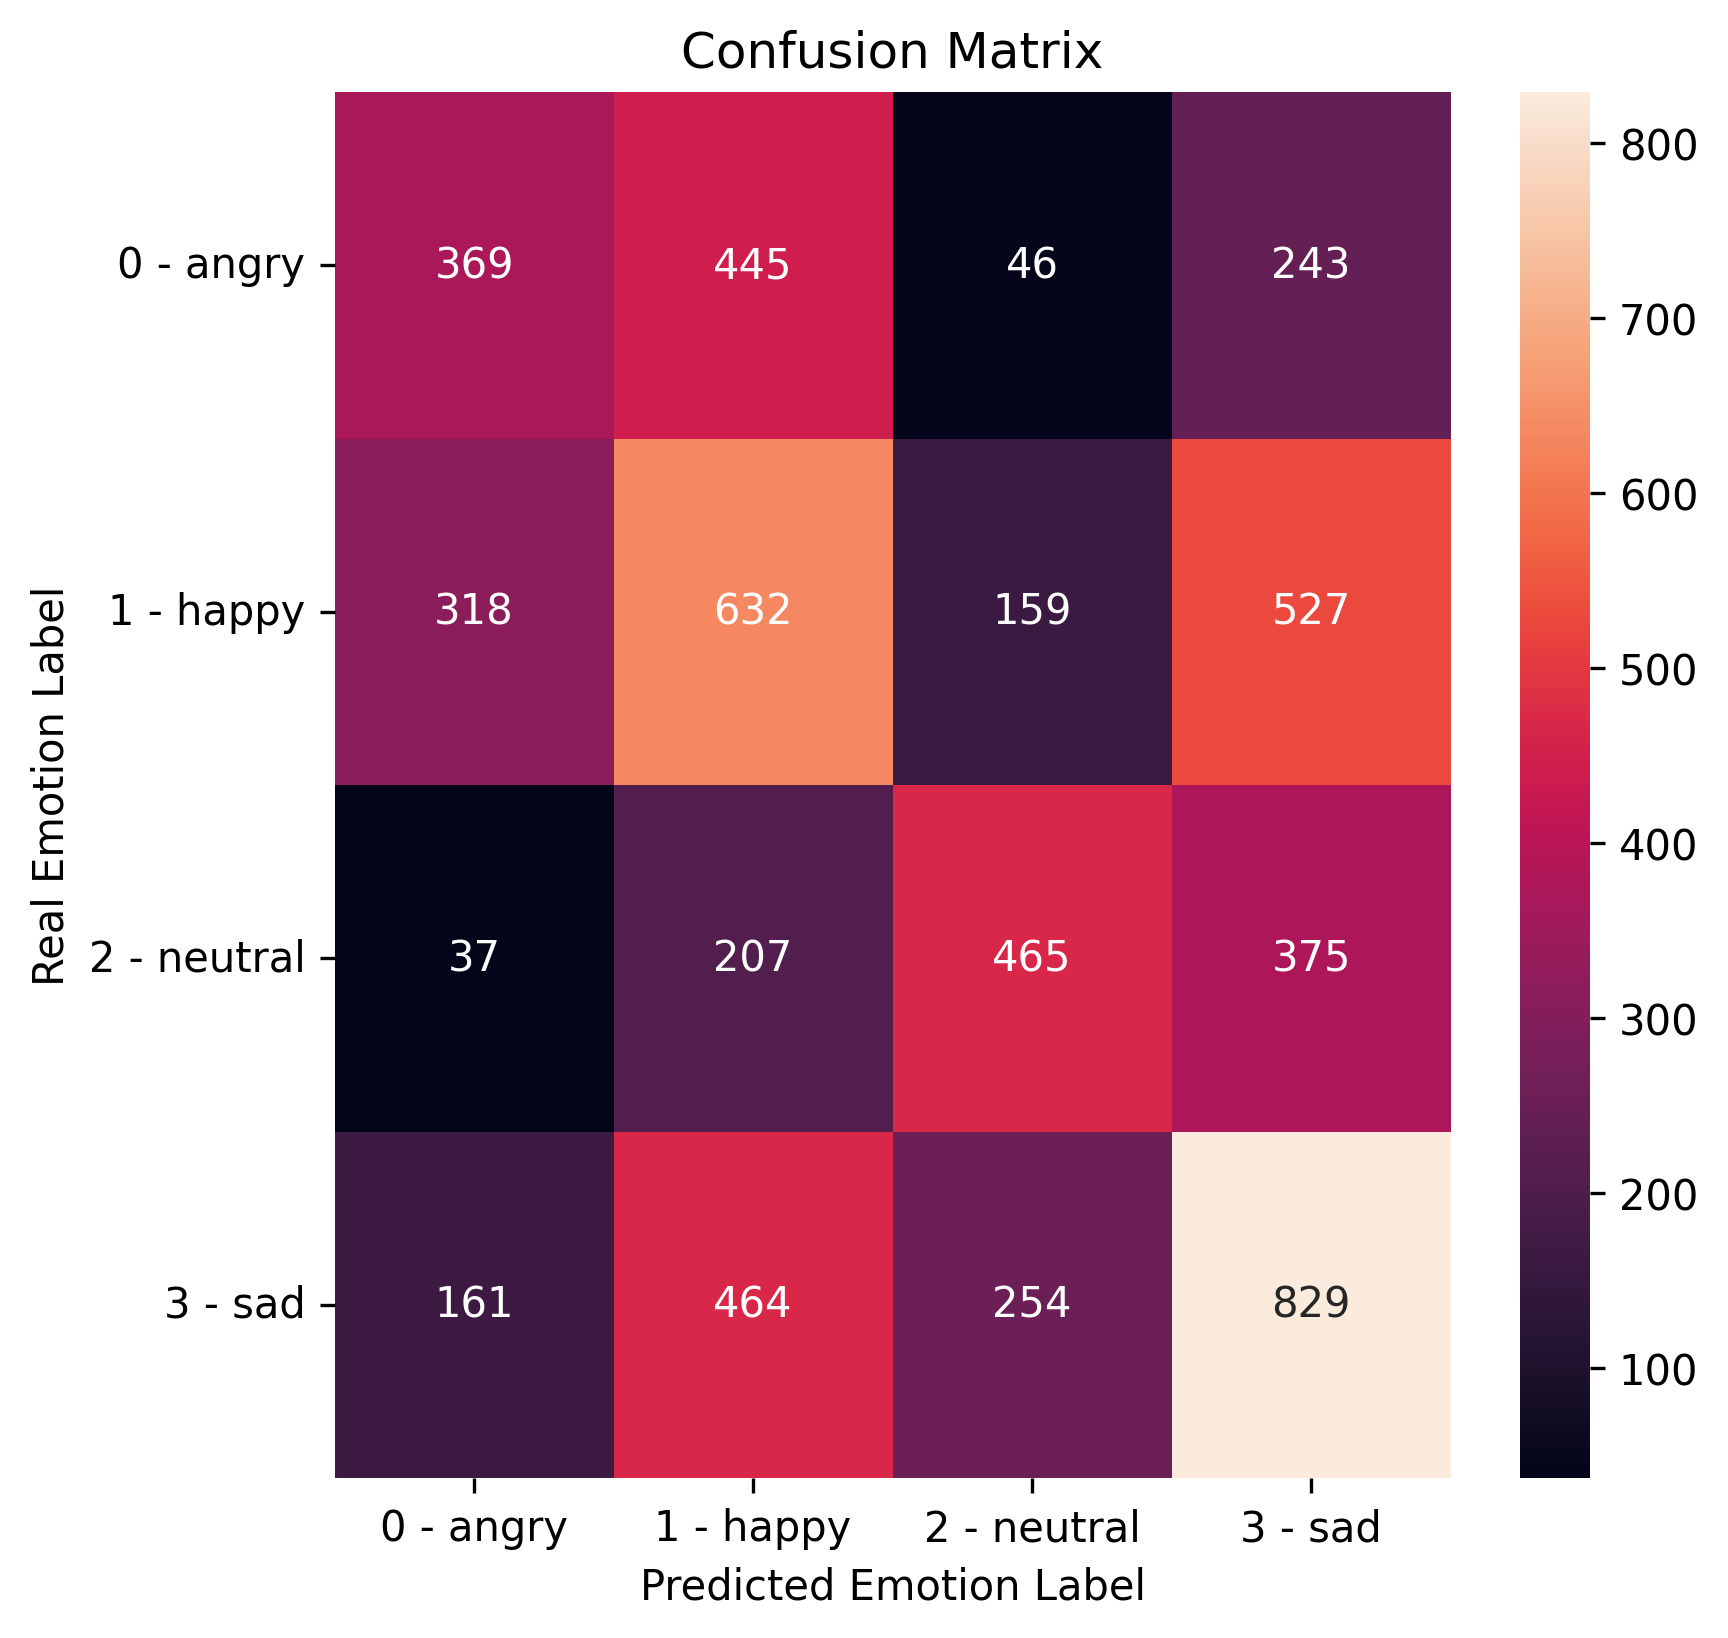

In [72]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

## Mel-Spectrogram as a Feature

In [73]:
data_df = pd.DataFrame({"x": [], "y": []})

def get_y_and_label(audio_file):
    with open(audio_file, 'rb') as f:
        y = pickle.load(f)
    emotion = audio_file.split("-")[1][0]
    return y, int(emotion)

for file in tqdm(glob.glob(f'{AUDIO_MEL_SPECTROGRAMS_DIR}*.pickle')):
    data_df.loc[len(data_df.index)] = get_y_and_label(file)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [00:49<00:00, 111.03it/s]


In [74]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 8s 96ms/step - loss: 1.4025 - accuracy: 0.4087
Epoch 2/50
70/70 [==============================] - 7s 98ms/step - loss: 1.1552 - accuracy: 0.4907
Epoch 3/50
70/70 [==============================] - 7s 101ms/step - loss: 1.0611 - accuracy: 0.5346
Epoch 4/50
70/70 [==============================] - 7s 104ms/step - loss: 0.9592 - accuracy: 0.5875
Epoch 5/50
70/70 [==============================] - 8s 107ms/step - loss: 0.8953 - accuracy: 0.6196
Epoch 6/50
70/70 [==============================] - 8s 108ms/step - loss: 0.8003 - accuracy: 0.6673
Epoch 7/50
70/70 [==============================] - 8s 107ms/step - loss: 0.7191 - accuracy: 0.7000
Epoch 8/50
70/70 [==============================] - 7s 106ms/step - loss: 0.6489 - accuracy: 0.7392
Epoch 9/50
70/70 [==============================] - 7s 104ms/step - loss: 0.5797 - accuracy: 0.7697
Epoch 10/50
70/70 [==============================] - 7s 105ms/step - loss: 0.5

Metric               Value
-----------------  -------
Accuracy            44.01
F1 score macro      44.82
Precision           44.64
Recall              45.12
Matthews corrcoef    0.244


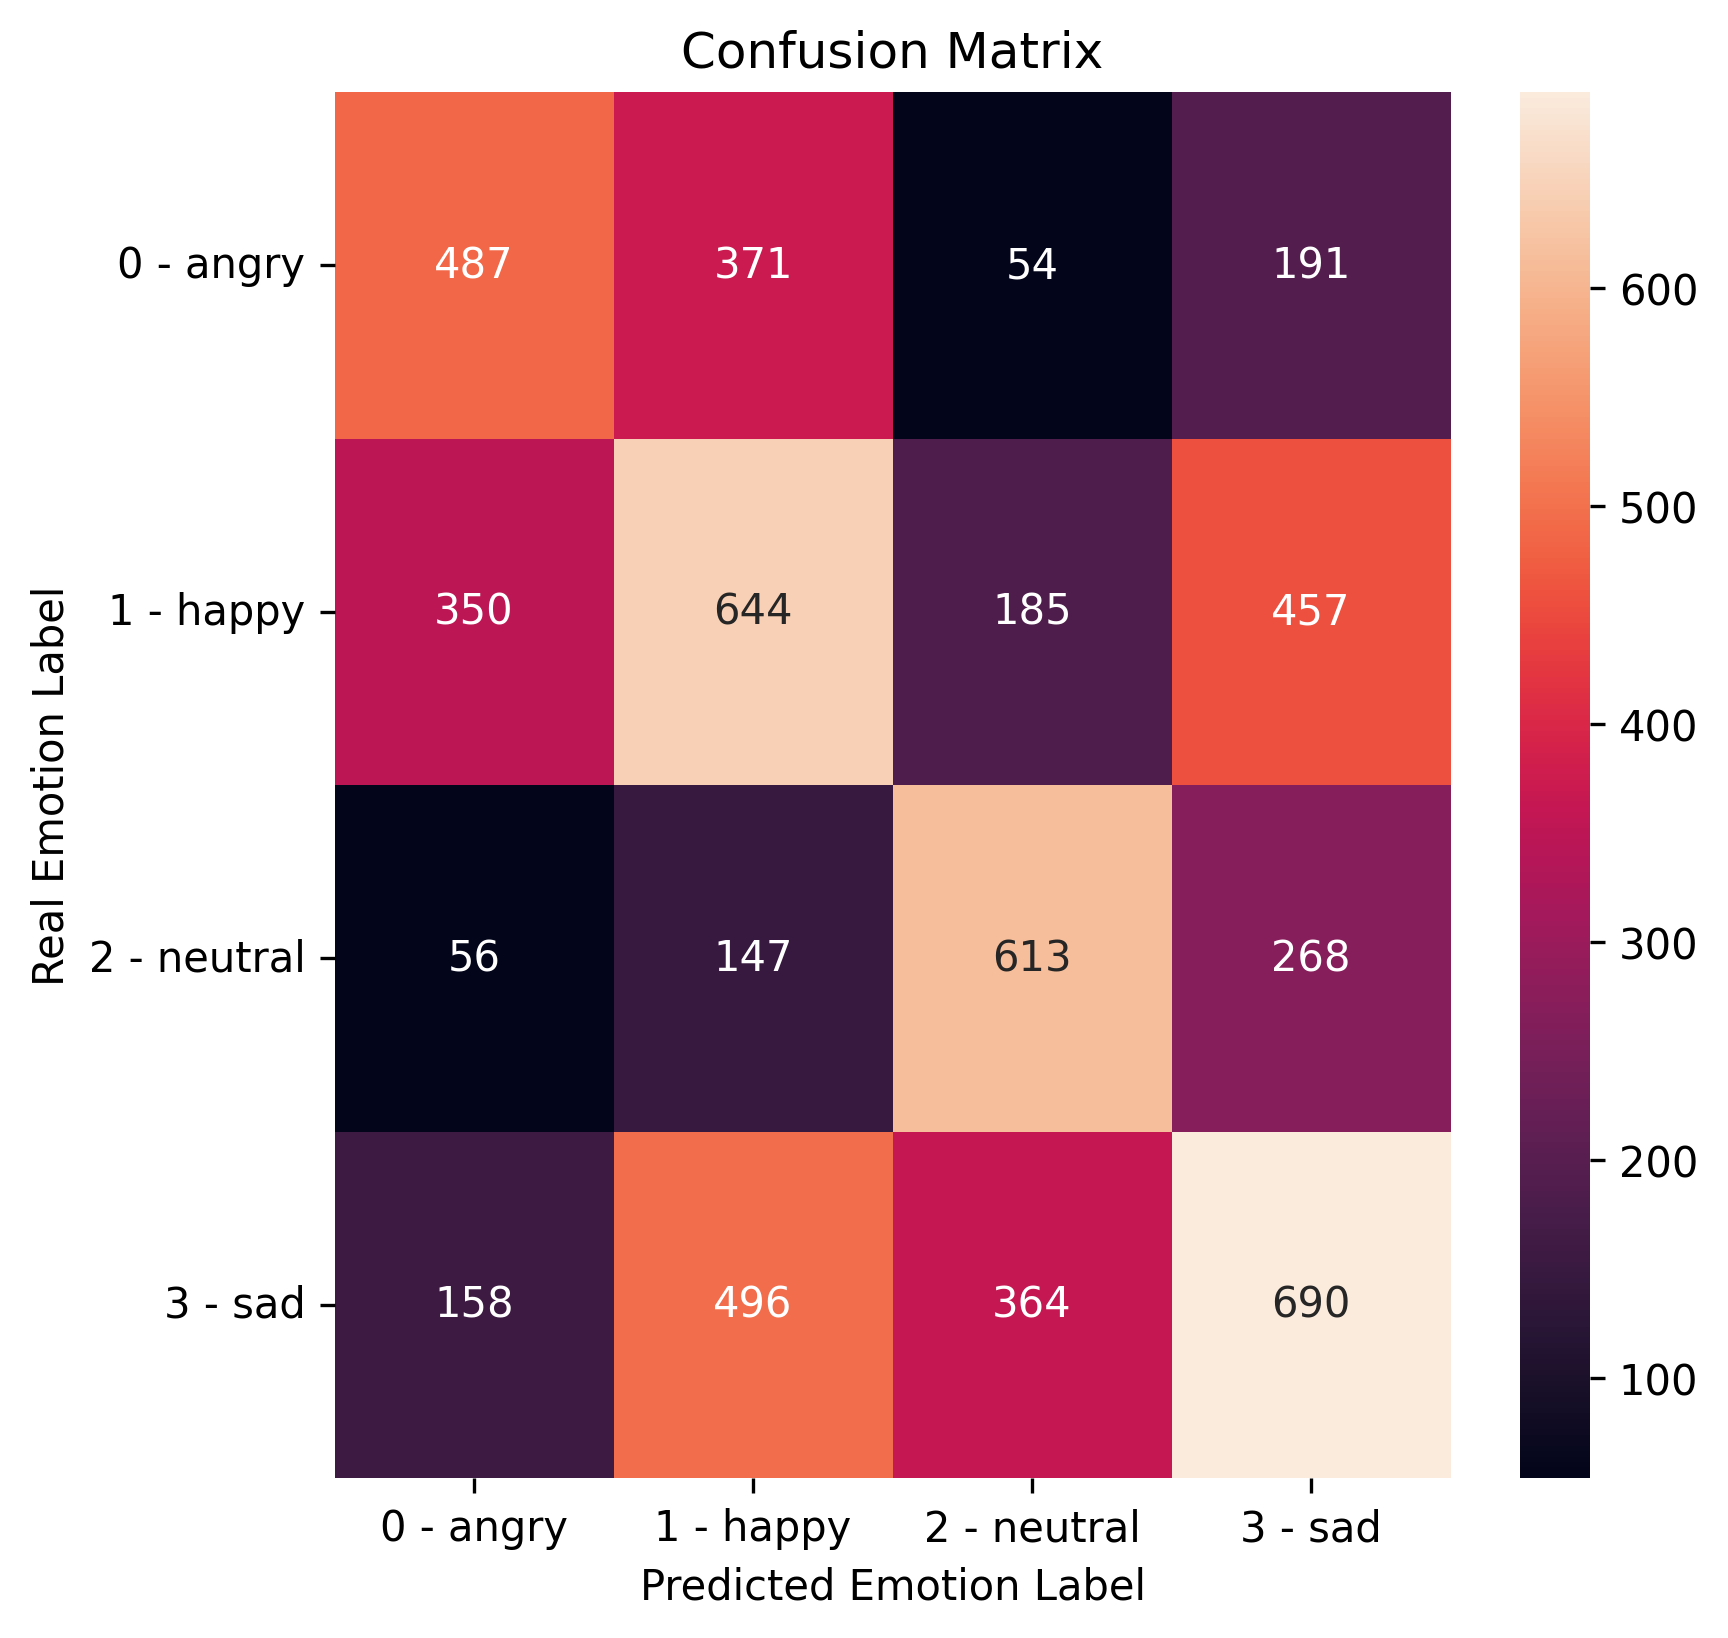

In [75]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

## Mel-Spectrogram Image as a Feature

In [4]:
data_df = pd.DataFrame({"x": [], "y": []})

def get_y_and_label(audio_file):
    y = np.array(Image.open(audio_file))
    y = np.resize(y, (256, 256, 3))
    y = y.astype('float64')
    y /= 255
    emotion = audio_file.split("-")[1][0]
    return y, int(emotion)

for file in tqdm(glob.glob(f'{AUDIO_MEL_SPECTROGRAM_IMAGES_DIR}*.png')):
    data_df.loc[len(data_df.index)] = get_y_and_label(file)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [00:18<00:00, 304.92it/s]


In [5]:
def build_model_1_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(32, (7, 7), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 3)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1_2(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)


Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 128, 128, 32)      4736      Y          
                                                                            
 activation (Activation)     (None, 128, 128, 32)      0         Y          
                                                                            
 batch_normalization (BatchN  (None, 128, 128, 32)     128       Y          
 ormalization)                                                              
                                                                            
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     Y          
                                                                            
 activation_1 (Activation)   (None, 64, 64, 64)        0         Y          
                                                        

In [6]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, 50, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 75s 1s/step - loss: 2.2974 - accuracy: 0.3556
Epoch 2/50
70/70 [==============================] - 66s 949ms/step - loss: 1.7013 - accuracy: 0.4028
Epoch 3/50
70/70 [==============================] - 68s 973ms/step - loss: 1.5132 - accuracy: 0.4247
Epoch 4/50
70/70 [==============================] - 72s 1s/step - loss: 1.3692 - accuracy: 0.4715
Epoch 5/50
70/70 [==============================] - 79s 1s/step - loss: 1.7326 - accuracy: 0.4175
Epoch 6/50
70/70 [==============================] - 82s 1s/step - loss: 1.5063 - accuracy: 0.4283
Epoch 7/50
70/70 [==============================] - 82s 1s/step - loss: 1.2268 - accuracy: 0.4921
Epoch 8/50
70/70 [==============================] - 72s 1s/step - loss: 1.1712 - accuracy: 0.5027
Epoch 9/50
70/70 [==============================] - 69s 991ms/step - loss: 1.1879 - accuracy: 0.5027
Epoch 10/50
70/70 [==============================] - 70s 996ms/step - loss: 1.1292 - 

KeyboardInterrupt: 

In [ ]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

# SOA Model 2

In [111]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (7, 7), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 3)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)


get_new_model().summary(show_trainable=True)


Model: "sequential_106"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_21 (Conv2D)          (None, 128, 128, 16)      2368      Y          
                                                                            
 activation_848 (Activation)  (None, 128, 128, 16)     0         Y          
                                                                            
 batch_normalization_742 (Ba  (None, 128, 128, 16)     64        Y          
 tchNormalization)                                                          
                                                                            
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        12832     Y          
                                                                            
 activation_849 (Activation)  (None, 64, 64, 32)       0         Y          
                                                    

## Mel-Spectrogram Image as a Feature

In [116]:
data_df = pd.DataFrame({"x": [], "y": []})

def get_y_and_label(audio_file):
    y = np.array(Image.open(audio_file))
    y = np.resize(y, (256, 256, 3))
    y = y.astype('float64')
    y /= 255
    emotion = audio_file.split("-")[1][0]
    return y, int(emotion)

for file in tqdm(glob.glob(f'{AUDIO_MEL_SPECTROGRAM_IMAGES_DIR}*.png')):
    data_df.loc[len(data_df.index)] = get_y_and_label(file)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [00:26<00:00, 204.88it/s]


In [117]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 75s 1s/step - loss: 1.8025 - accuracy: 0.3508
Epoch 2/50
70/70 [==============================] - 60s 856ms/step - loss: 1.4068 - accuracy: 0.4297
Epoch 3/50
70/70 [==============================] - 59s 849ms/step - loss: 1.3713 - accuracy: 0.4613
Epoch 4/50
70/70 [==============================] - 64s 914ms/step - loss: 1.2693 - accuracy: 0.4717
Epoch 5/50
70/70 [==============================] - 70s 1s/step - loss: 1.2167 - accuracy: 0.5014
Epoch 6/50
70/70 [==============================] - 74s 1s/step - loss: 1.1787 - accuracy: 0.4934
Epoch 7/50
70/70 [==============================] - 85s 1s/step - loss: 1.1477 - accuracy: 0.5292
Epoch 8/50
70/70 [==============================] - 84s 1s/step - loss: 1.0470 - accuracy: 0.5674
Epoch 9/50
70/70 [==============================] - 82s 1s/step - loss: 1.0226 - accuracy: 0.5780
Epoch 10/50
70/70 [==============================] - 71s 1s/step - loss: 1.0111 - acc

Accuracy for fold 0: 44.12%
Accuracy for fold 1: 43.58%
Accuracy for fold 2: 48.73%
Accuracy for fold 3: 48.1%
Accuracy for fold 4: 48.73%

Metric             Value
-----------------  -----------
Accuracy           46.65+-2.31
F1 score macro     46.43
Precision          47.84
Recall             46.08
Matthews corrcoef  0.273


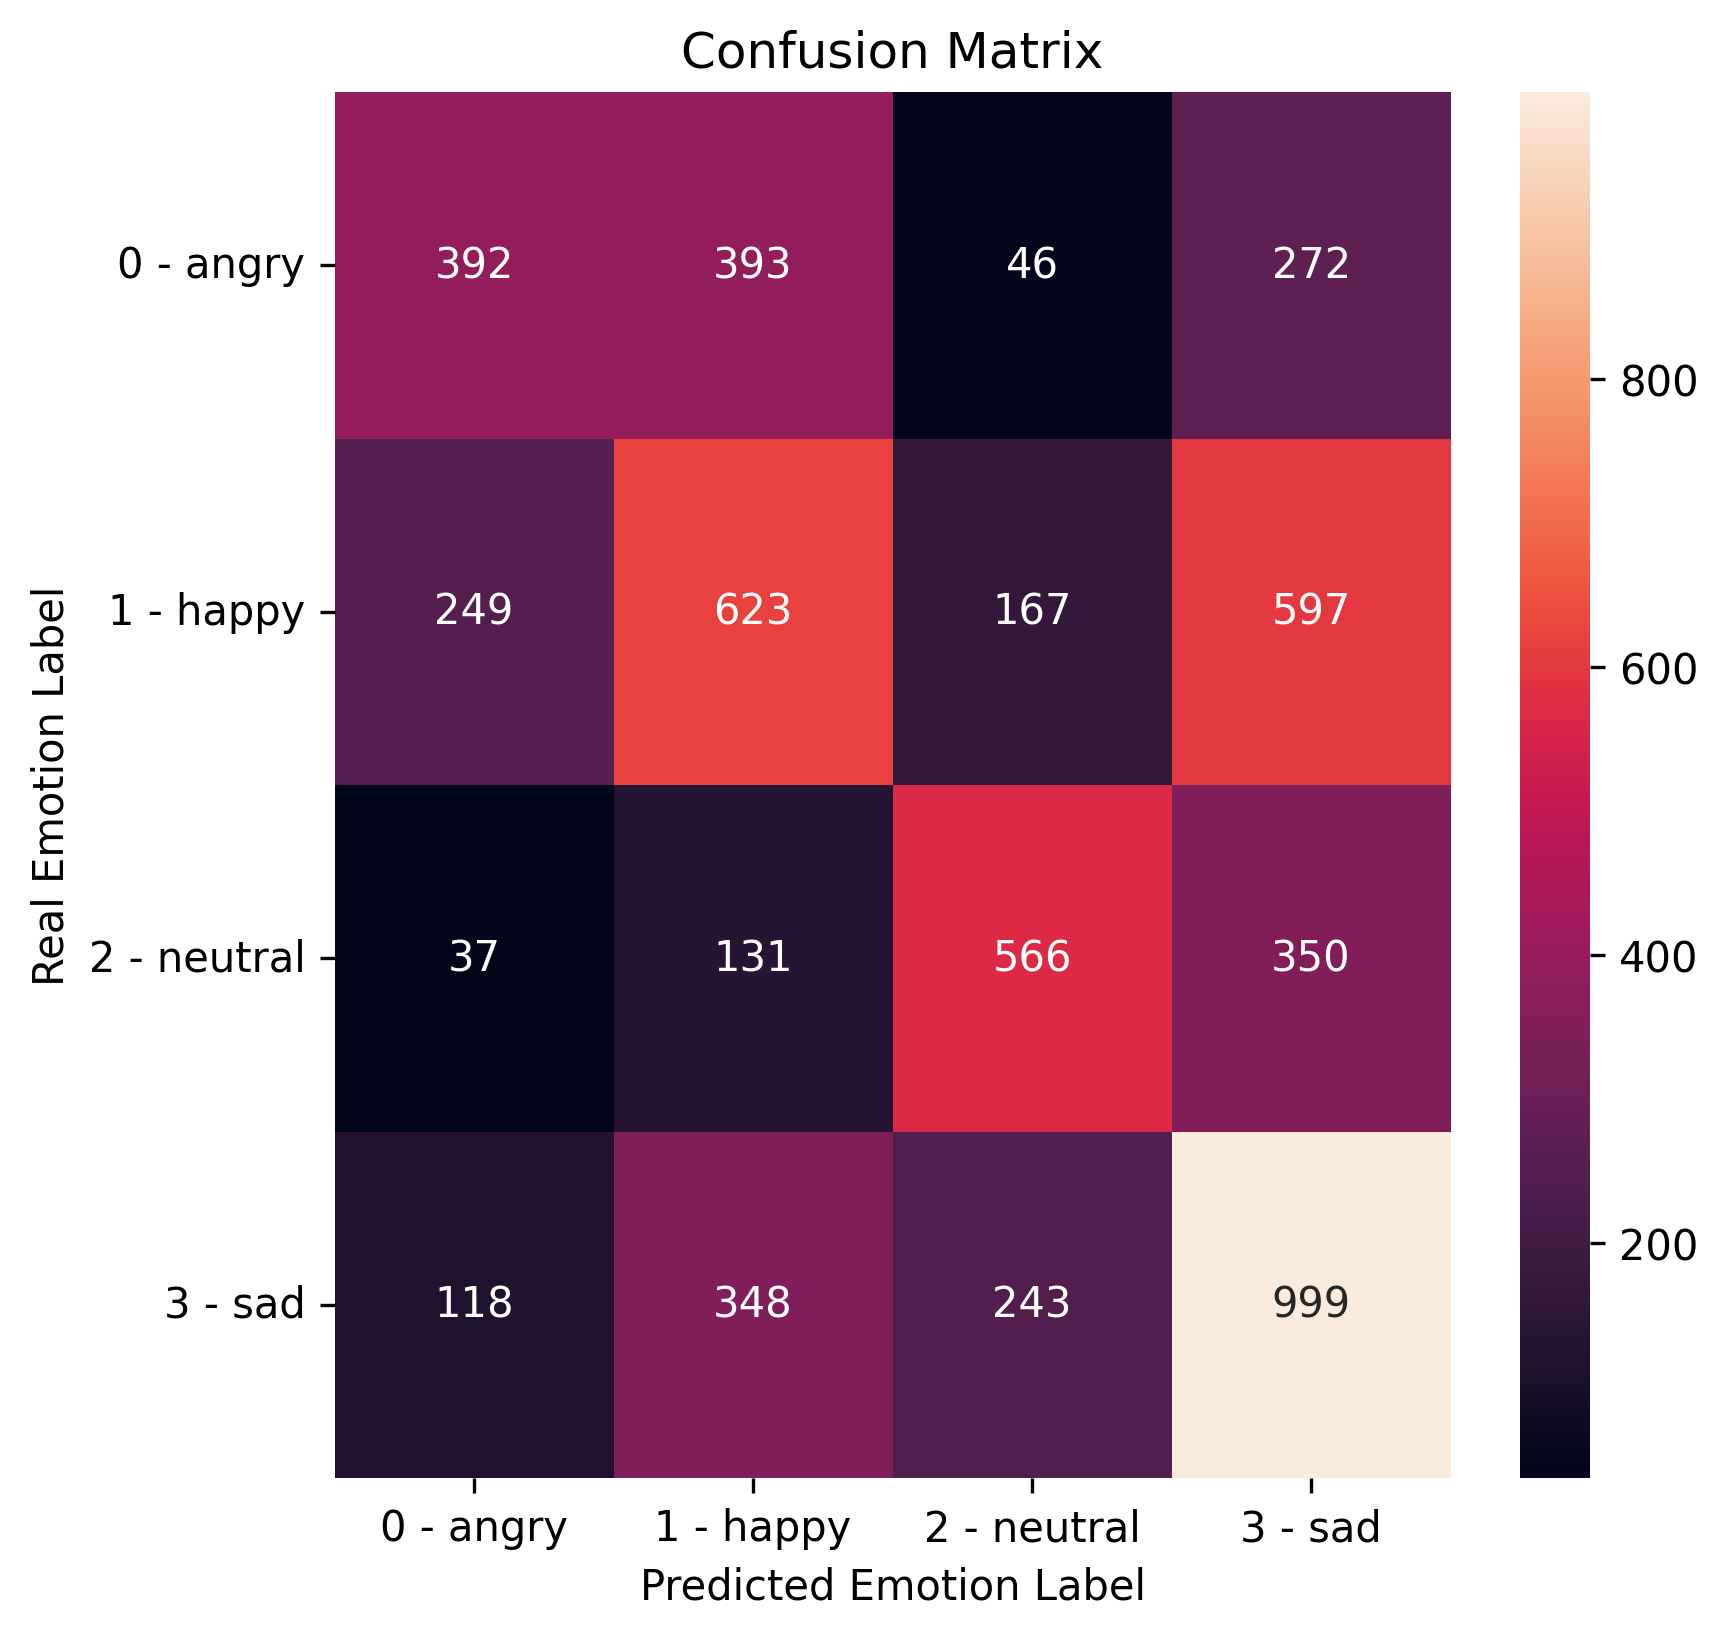

In [ ]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

# Transfer Learning

## VGG-16

In [4]:
# Load pretrained model VGG16
vgg16_model = tf.keras.applications.VGG16(
              weights="imagenet", 
              input_shape=(224, 224, 3),
              include_top = False)
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
def get_new_model():
    vgg16_model = tf.keras.applications.VGG16(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False)
    vgg16_model.trainable = False
    inputs = tf.keras.Input(shape=(224,224,3))
    x = vgg16_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


get_new_model().summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_____________________________________________

In [5]:
# Pre-processing Images for VGG-16
def tf_load_process_image(filename):
  img_size = 224
  image_original = load_img(filename, target_size=(img_size, img_size))
  image_array = img_to_array(image_original)
  image_preprocessed = tf.keras.applications.vgg16.preprocess_input(
      image_array)
  return image_preprocessed

data_df = pd.DataFrame({"x": [], "y": []})

def get_y_and_label(audio_file):
    return tf_load_process_image(audio_file), audio_file.split("-")[1][0]

for file in tqdm(glob.glob(f'{AUDIO_MEL_SPECTROGRAM_IMAGES_DIR}*.png')):
    data_df.loc[len(data_df.index)] = get_y_and_label(file)

data_df["y"] = data_df["y"].astype(int)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [00:15<00:00, 346.54it/s]


In [6]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, 50, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 537s 8s/step - loss: 3.1381 - accuracy: 0.2708
Epoch 2/50
70/70 [==============================] - 541s 8s/step - loss: 1.8625 - accuracy: 0.3861
Epoch 3/50
70/70 [==============================] - 530s 8s/step - loss: 1.5410 - accuracy: 0.4085
Epoch 4/50
70/70 [==============================] - 532s 8s/step - loss: 1.3364 - accuracy: 0.4503
Epoch 5/50
70/70 [==============================] - 528s 8s/step - loss: 1.2157 - accuracy: 0.4810
Epoch 6/50
61/70 [=========================>....] - ETA: 1:08 - loss: 1.1699 - accuracy: 0.4882

KeyboardInterrupt: 

## ResNet50

In [6]:
def get_new_model():
    resnet_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        classes=1000
    )
    resnet_model.trainable = False
    inputs = tf.keras.Input(shape=(224,224,3))
    x = resnet_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


get_new_model().summary()


94765736/94765736 [==============================] - 10s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainabl

In [7]:
# Pre-processing Images for VGG-16
def tf_load_process_image(filename):
  img_size = 224
  image_original = load_img(filename, target_size=(img_size, img_size))
  image_array = img_to_array(image_original)
  image_preprocessed = tf.keras.applications.resnet50.preprocess_input(
      image_array)
  return image_preprocessed

data_df = pd.DataFrame({"x": [], "y": []})

def get_y_and_label(audio_file):
    return tf_load_process_image(audio_file), audio_file.split("-")[1][0]

for file in tqdm(glob.glob(f'{AUDIO_MEL_SPECTROGRAM_IMAGES_DIR}*.png')):
    data_df.loc[len(data_df.index)] = get_y_and_label(file)

data_df["y"] = data_df["y"].astype(int)

  0%|          | 0/5531 [00:00<?, ?it/s]c:\Users\MárioSilva\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
100%|██████████| 5531/5531 [00:17<00:00, 315.61it/s]


In [48]:
AUTOTUNE = tf.data.AUTOTUNE
spec_df = pd.read_csv(RAW_AUDIO_FILES)
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin(
    {'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1


def get_y_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    return tf_load_process_image(audio_file), int(audio_file.split("-")[1][0])

def get_y_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    return tf_load_process_image(audio_file), int(OneHotEncodingConfig[audio_file.split("-")[1][0]])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [224, 224, 3]), tf.reshape(labels, [1])

def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_y_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [224, 224, 3]), tf.reshape(labels, [4])

def preprocess_dataset(files, oneHotEncoding=False):
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:/Users/MárioSilva/Desktop/VADER/Audio_Sentiment_Analysis/iemocap/data/mel_spectrogram_images/{file.split('/')[-1][:-4]}-{str(spec_df.loc[f'/Users/mario/{file[13:]}']['Emotion_Id'])}.png" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


In [54]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 4:5]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds)
    train_ds = train_ds.batch(64)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds, True)
    test_ds = test_ds.batch(64)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred


y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Training for fold 1 ...
Epoch 1/100
70/70 [==============================] - 378s 5s/step - loss: 1.3971 - accuracy: 0.3811
Epoch 2/100
70/70 [==============================] - 394s 6s/step - loss: 1.1689 - accuracy: 0.4849
Epoch 3/100
70/70 [==============================] - 405s 6s/step - loss: 1.0817 - accuracy: 0.5145
Epoch 4/100
24/70 [=========>....................] - ETA: 4:38 - loss: 1.0690 - accuracy: 0.5456

In [8]:
y_labels = categorical_cross_validation(
    get_new_model, data_df, callback, 50, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
43/70 [=================>............] - ETA: 1:55 - loss: 1.6393 - accuracy: 0.3379

KeyboardInterrupt: 